In [61]:
import numpy as np
import torch

traindata = np.loadtxt("data/Lazer/train.txt")
testdata = np.loadtxt("data/Lazer/test.txt")  #
name    = "Lazer"
hidden = 5
input = 4  #
output = 1
prob_type = 'regression'

In [62]:
train_features = torch.tensor(traindata[:,:-1],dtype=torch.float32)
train_target   = torch.tensor(traindata[:,-1],dtype=torch.float32)
test_features  = torch.tensor(testdata[:,:-1],dtype=torch.float32)
test_target    = torch.tensor(testdata[:,-1],dtype=torch.float32)
print(train_features.shape,train_target.shape,test_features.shape,test_target.shape)

torch.Size([298, 4]) torch.Size([298]) torch.Size([198, 4]) torch.Size([198])


In [39]:
import torch
from torch import nn
linreg = nn.Linear(4,1)
nnreg = nn.Sequential(
    nn.Linear(4,5),
    nn.Linear(5,1)
)
def encodeSeq(model):
    return torch.cat([x.flatten() for x in model.parameters()])
def decodeSeq(model, params):
    pflat = params.flatten()
    #print("params",params,pflat)
    #print(model)
    cumidx = 0
    for p in model.parameters():
        #print("model p",p.data)
        nneurons = torch.numel(p)
        p.data = pflat[cumidx:cumidx+nneurons].reshape(p.data.shape)
        cumidx += nneurons

from Code.mcmc_v2 import (
    MetropolisHastings, 
    ProposeFuncBlueprint, RandomWalkProposal, 
    AcceptRejectBlueprint, MHAcceptReject,
    TargetFuncBlueprint
)
class WeightVarianceJointProposal(ProposeFuncBlueprint):
    def __init__(self,std):
        self.std = std
    def propose(self,last_sample):
        """Propose the next sample base or without the last, 
            e.g. random walk with last sample as mean, langevin gradient
        """
        # assume last_sample of shape [1,nnweight+precision]
        new = torch.zeros_like(last_sample)
        new[:,:-1] = torch.distributions.Normal(loc=last_sample, std = self.std)
        new[:,-1]  = torch.distributions.Gamma(1.1,6).sample([new.shape[0]])
        return new
    def log_prob(self,sample,cond_sample):
        # return only gamma because random walk cancels
        return torch.distributions.Gamma(1.1,6).log_prob(sample[:,-1])
        
        # BELOW IS ACTUALLY THE PREDICTIVE P(THETA|X)
        #return torch.distributions.Gamma(
        #    1.1+sample_size/2,
        #    6+sample_size+nn.MSELoss(reduction = "sum")(self.model(self.features),self.target)
        #).log_prob(sample)
class LinRegTarget(TargetFuncBlueprint):
    def __init__(self,features,target, model:nn.Module, decodeparam: callable):
        self.features = features
        self.target = target
        self.model = model
        self.decodeparam = decodeparam
    def eval_log(self,sample):
        #yi = B*Xi + eps
        #eps \sim N(0,theta)
        #
        #print("target debug:",sample)
        self.decodeparam(self.model,sample[:,:-1])
        """ precision = 1/var = 1/sigma^2,
        """
        precision = sample[0,-1]
        #print(self.features.dtype)
        #for p in self.model.parameters():
        #    print(p.data.dtype)
        pred = self.model(self.features)

        like = self.target.shape[0]*torch.log(precision)-precision*nn.MSELoss(reduction="mean")(self.target,pred.squeeze())
        #print("pred:",pred.shape)
        #print("loss:",(nn.MSELoss()(self.target,pred.squeeze())/(var)).shape)
        #print("like:",like)
        return like,pred
device = torch.device("cpu")
proposal = RandomWalkProposal(0.5, device)
target = LinRegTarget(
    torch.tensor(train_features, dtype = torch.float32), 
    torch.tensor(train_target,dtype = torch.float32), 
    linreg, decodeSeq)
ar = MHAcceptReject(proposal, target, device , ini_pred= torch.zeros(*train_target.shape,1), debug = False)
mh = MetropolisHastings(
    propose_func = proposal,
    accept_reject = ar,
    initial_sample = torch.tensor([[1,2,3,4,1,0.5]]),#torch.rand(1,4+1+1), #features + bias + var
    device = device,
    iterations = 40000,
    burnin= 1000,
    save_prediction= True,
    prediction_shape = [train_target.shape[0],1]
)
out = mh.startSampling(debug=False)


In [11]:
out[-1].shape

torch.Size([25000, 298, 1])

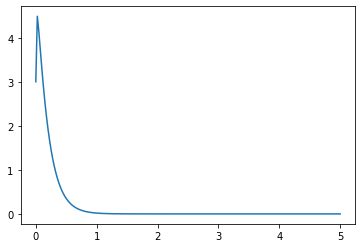

In [ ]:
g = torch.distributions.Gamma(1.1,6)
import matplotlib.pyplot as plt
x = torch.linspace(0.0001,5,200)
y = torch.exp(g.log_prob(x))
plt.plot(x,y)

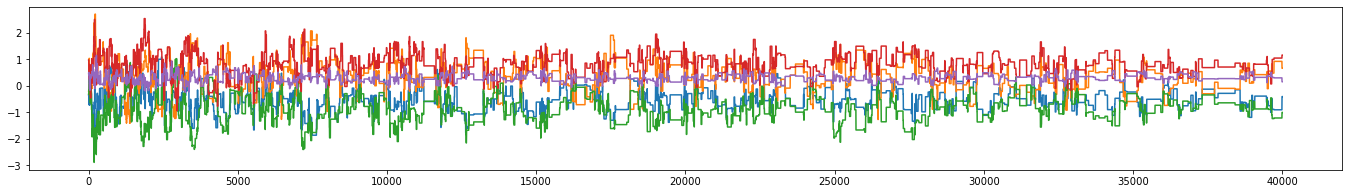

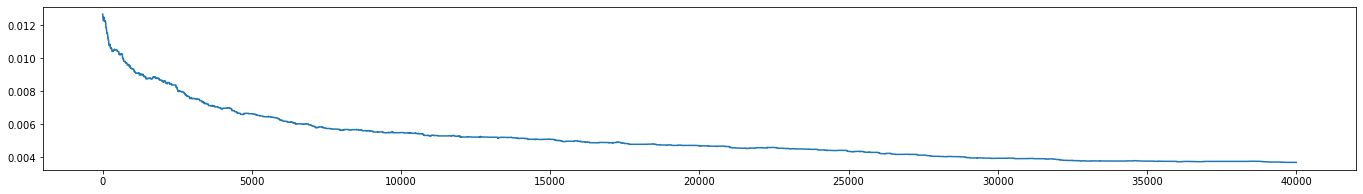

In [40]:
params = out[0]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(80,3))
ax = fig.add_subplot(1,3,1)
for i in range(5):
    ax.plot(params[:,:,i])
fig = plt.figure(figsize=(80,3))
ax = fig.add_subplot(1,3,2)
ax.plot(1/params[:,:,5])




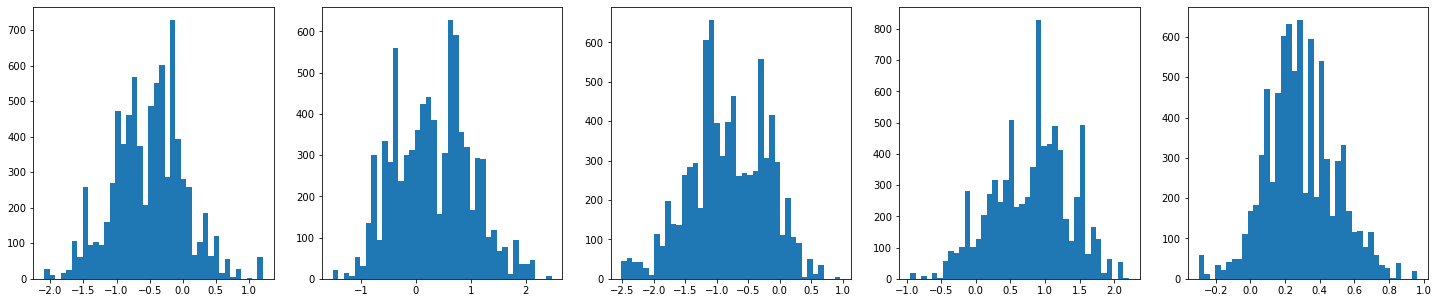

In [12]:
fig2 = plt.figure(figsize=(25,5))
for i in range(5):
    ax = fig2.add_subplot(1,5,i+1)
    ax.hist(params[:,:,i].detach().cpu().numpy(), bins = 40)

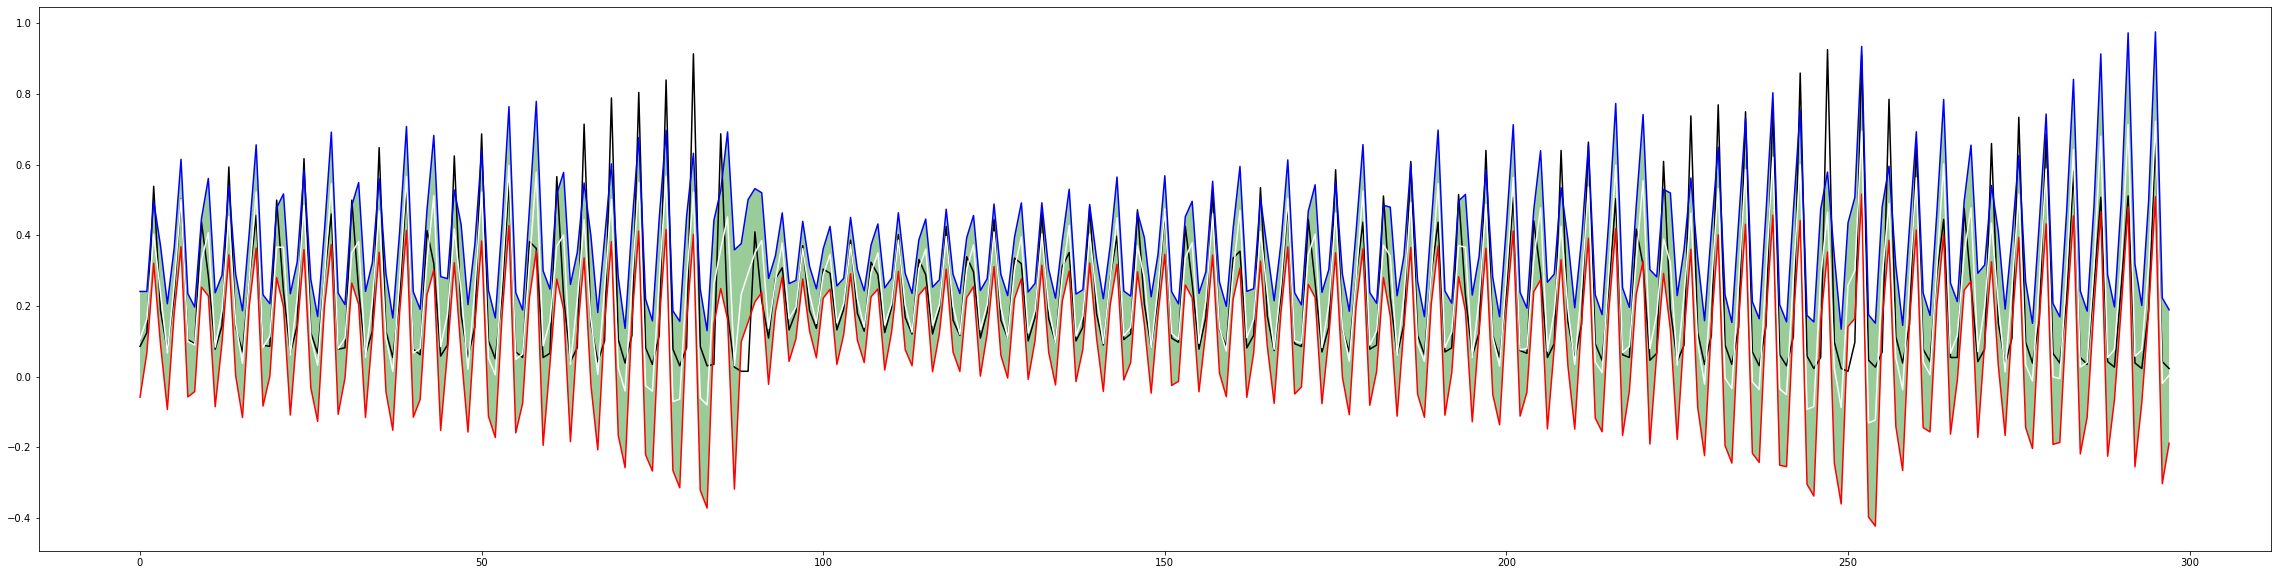

In [47]:
fig = plt.figure(figsize=(40,10))
#ax = fig.add_subplot(1,3,1)
#ax.plot(train_target,'-k')
preds = out[-1].detach().cpu()[-10000:,:,:]
q05 = torch.quantile(preds,0.05,dim=0).flatten()
q50 = torch.quantile(preds,0.50,dim=0).flatten()
q95 = torch.quantile(preds,0.95,dim=0).flatten()
ax = fig.add_subplot(1,1,1)
ax.plot(list(range(len(train_target))),train_target,"-k")
ax.plot(list(range(len(train_target))),q05,'-r')
ax.plot(list(range(len(train_target))),q95,'-b')
ax.plot(list(range(len(train_target))),q50,'-w')
ax.fill_between(list(range(len(train_target))),q05, q95, facecolor='g', alpha=0.4)



In [41]:
sample, accept, total, evals, preds = out
print(accept,total)

1364 41000


# roulette

In [85]:
from Code.gan_v2 import NetWrapper, vanilla_disc_act, VanillaDiscriminatorStep, VanillaGeneratorStep, TogetherLoop, VisLoss
import torch
from torch import nn, optim
import torch.distributions as D
from torch.utils.data import DataLoader
class base_generator(nn.Module):
    def __init__(self,lat_len = 2,out_len = 2): # default for 2d gaus problem
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(lat_len, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, out_len),
        )
    def forward(self,x):
        return self.main(x)
class base_discriminator(nn.Module):
    def __init__(self,sample_len,out_len):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(sample_len, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, out_len),
            nn.ReLU(),
        )

    def forward(self, input):
        return self.main(input)
class base_generator1(nn.Module):
    def __init__(self,lat_len = 2,out_len = 2): # default for 2d gaus problem
        super().__init__()
        self.start = nn.Sequential(
            nn.Linear(lat_len, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
        )
        self.res1 = nn.Sequential(
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
        )
        self.res2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
        )
        self.end = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, out_len),
        )
    def forward(self,x):
        y = self.start(x)
        z = self.res1(y)
        a = nn.LeakyReLU(0.2)(y+z)
        b = self.res2(a)
        c = nn.LeakyReLU(0.2)(a+b)
        return self.end(c)
class base_discriminator1(nn.Module):
    def __init__(self,sample_len,out_len): # default for 2d gaus problem
        super().__init__()
        self.start = nn.Sequential(
            nn.Linear(sample_len, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
        )
        self.res1 = nn.Sequential(
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
        )
        self.res2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
        )
        self.end = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, out_len),
        )
    def forward(self,x):
        y = self.start(x)
        z = self.res1(y)
        a = nn.LeakyReLU(0.2)(y+z)
        b = self.res2(a)
        c = nn.LeakyReLU(0.2)(a+b)
        return self.end(c)

In [49]:
mh = MetropolisHastings(
    propose_func = proposal,
    accept_reject = ar,
    initial_sample = torch.tensor([[1,2,3,4,1,0.5]]),#torch.rand(1,4+1+1), #features + bias + var
    device = device,
    iterations = 2000,
    burnin= 1000,
    save_prediction= True,
    prediction_shape = [train_target.shape[0],1]
)
out = mh.startSampling(debug=False)
sample, accept, total, evals, preds = out

In [59]:
sample.shape 

torch.Size([2000, 1, 6])

discriminator loss


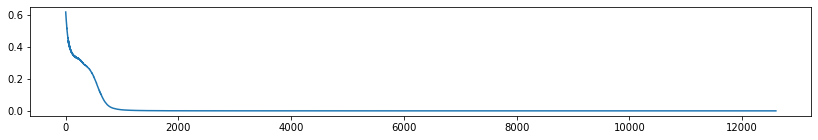

generator loss


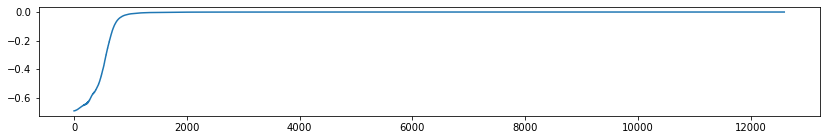

/home/sean/miniconda3/envs/qttrade/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([298])) that is different to the input size (torch.Size([298, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [88]:
device = torch.device("cpu")#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gen = base_generator1(lat_len=2,out_len=6).to(device)
dis = NetWrapper(
    base_discriminator1(sample_len=6,out_len = 16),
    vanilla_disc_act(input_dim = 16)
).to(device)
batch_size = 32
lr = 0.00005
goptim = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999)) # betas=(0,0.9))#
doptim = optim.Adam(dis.parameters(), lr=lr, betas=(0.5, 0.999)) # betas=(0,0.9))#
latent = lambda batch_size: torch.randn(batch_size,2,device=device)

train_loader = DataLoader(sample.squeeze(), batch_size=batch_size, shuffle=True)
train = TogetherLoop(
    VanillaGeneratorStep, VanillaDiscriminatorStep,
    goptim, doptim,
    latent,
    gen, dis,
    train_loader, 200, device
)
train.train(visloss=VisLoss)

crude_samples = gen(latent(2000))
fake_mh_samples = torch.zeros_like(crude_samples)
# now assumes a symmetric proposal which it isn't
last_score = -torch.inf
count = 0
for i in range(2000):
    x = crude_samples[i,:]
    decodeSeq(linreg,x[:-1])
    pred = linreg(train_features)
    new_score = train_target.shape[0]*torch.log(x[-1])-nn.MSELoss(reduction="sum")(pred,train_target)*x[-1]
    arrate = torch.min(torch.ones(1),torch.exp(new_score-last_score))
    u = torch.rand(1)
    if u<arrate:
        fake_mh_samples[i,:] = crude_samples[i,:]
        last_score = new_score
        count += 1
    else:
        fake_mh_samples[i,:] = fake_mh_samples[i-1,:]

In [74]:
crude_samples.shape

torch.Size([2000, 6])

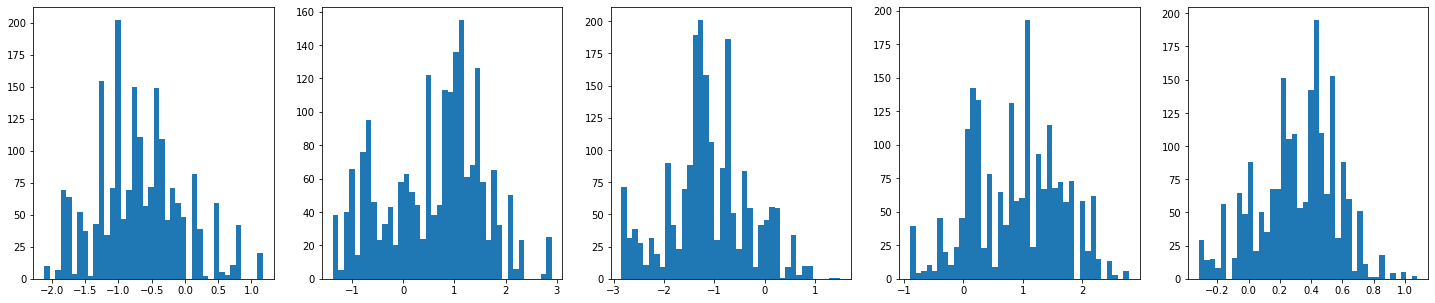

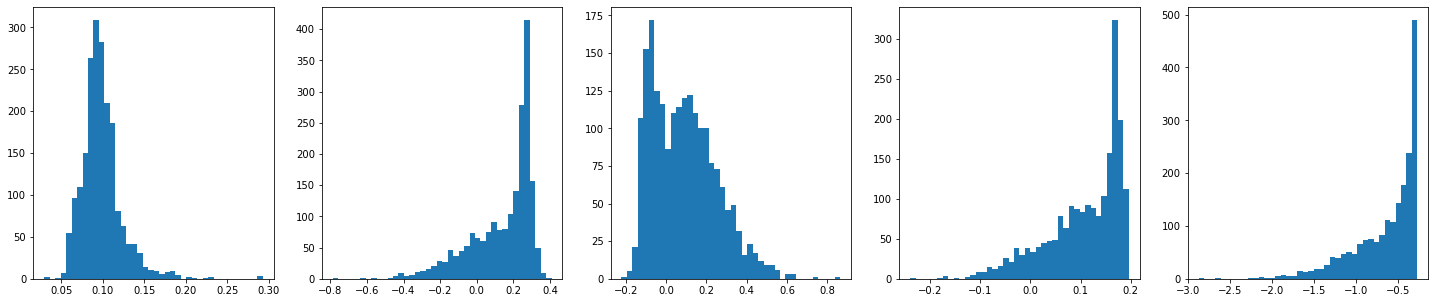

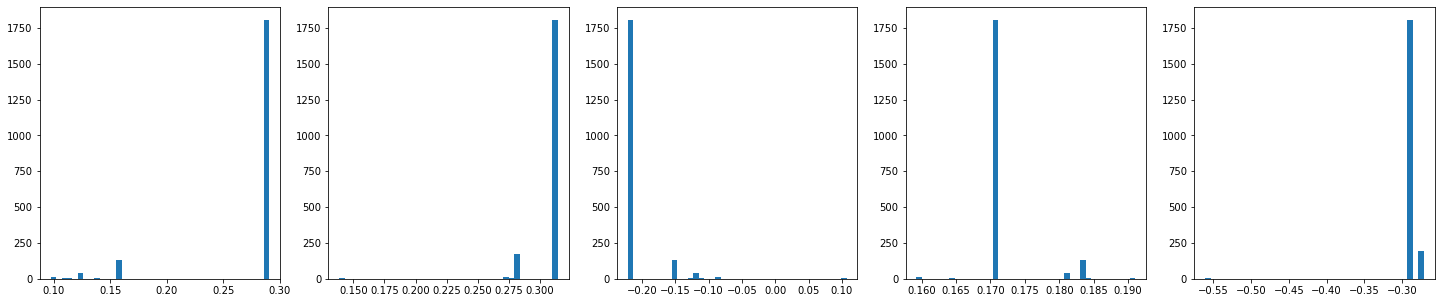

In [87]:
fig1 = plt.figure(figsize=(25,5))
for i in range(5):
    ax = fig1.add_subplot(1,5,i+1)
    ax.hist(sample[:,:,i].detach().cpu().numpy(), bins = 40)
fig2 = plt.figure(figsize=(25,5))
for i in range(5):
    ax = fig2.add_subplot(1,5,i+1)
    ax.hist(crude_samples[:,i].detach().cpu().numpy(), bins = 40)
fig2 = plt.figure(figsize=(25,5))
for i in range(5):
    ax = fig2.add_subplot(1,5,i+1)
    ax.hist(fake_mh_samples[:,i].detach().cpu().numpy(), bins = 40)

In [73]:
print(count)

8
